In [22]:
import torch

In [23]:
print("GPU found: ", torch.cuda.device_count())
print("GPU: ", torch.cuda.get_device_name())

GPU found:  1
GPU:  NVIDIA GeForce RTX 3050 Laptop GPU


In [24]:
!git clone https://github.com/indobenchmark/indonlu.git

fatal: destination path 'indonlu' already exists and is not an empty directory.


In [25]:
import pandas as pd
import numpy as np
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import defaultdict
import random

In [26]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from indonlu.utils.data_utils import DocumentSentimentDataset, DocumentSentimentDataLoader
from indonlu.utils.forward_fn import forward_sequence_classification
from indonlu.utils.metrics import document_sentiment_metrics_fn
from torch.utils.data import Dataset

In [27]:
df = pd.read_csv(r'clean-sentiment.csv')
df

,merge_text,sentiment
0,barang sesuai gambar pengiriman sesuai jadwal,neutral
1,barang cepat l keras overall good semoga awet,positive
2,produk pengiriman,negative
3,barang sesuai,positive
4,bingung install softwarenya enggak komplit eng...,positive
...,...,...
4973,warna sesuai pilihan port menyala,positive
4974,barang terima tinggal test terima kasih gan,positive
4975,bagus terima kasih sukses,positive
4976,mantap gan barang sempurna awet thanks ya gan,positive


In [28]:
print(df['sentiment'].isnull().sum())

0


In [29]:
df

df.to_csv('dataset_clean.tsv', sep='\t', header=None, index=False)

In [30]:
train_df, valid_df = train_test_split(df, test_size=0.3, stratify=df.sentiment, random_state=42)
valid_df, test_df = train_test_split(valid_df, test_size=0.33, stratify=valid_df.sentiment, random_state=42)

In [31]:
print(f'Ukuran Train: {train_df.shape}')
print(f'Ukuran Validation: {valid_df.shape}')
print(f'Ukuran Test: {test_df.shape}')

Ukuran Train: (3484, 2)
Ukuran Validation: (1000, 2)
Ukuran Test: (494, 2)


In [32]:
train_df.to_csv('train.tsv', sep='\t', header=None, index=False)
valid_df.to_csv('eval.tsv', sep='\t', header=None, index=False)
test_df.to_csv('test_df.tsv', sep='\t', header=None, index=False)

In [33]:
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

def count_param(module, trainable=False):
  if trainable:
    return sum(p.numel() for p in module.parameters() if p.requires_grad)
  else:
    return sum(p.numel() for p in module.parameters())

def get_lr(optimizer):
  for param_group in optimizer.param_groups:
    return param_group['lr']

def metrics_to_string(metric_dict):
  string_list = []
  for key, value in metric_dict.items():
    string_list.append('{}:{:.2f}'.format(key, value))
  return ', '.join(string_list)

set_seed(42)
print(set_seed)

<function set_seed at 0x000002098A34A160>


In [34]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')
config = BertConfig.from_pretrained('indobenchmark/indobert-base-p2')
config.num_labels = DocumentSentimentDataset.NUM_LABELS
model = BertForSequenceClassification.from_pretrained('indobenchmark/indobert-base-p2', config=config)
print(model)
print(count_param(model))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [35]:
merge_text = df.merge_text.values
tokenized_texts = tokenizer.tokenize(merge_text[3])

input_ids = []

for text in merge_text:
  encoded_text = tokenizer.encode(
      text,
      add_special_tokens=True,
  )
  input_ids.append(encoded_text)

print("Asli:", merge_text[3])
print("Tokenized:", tokenized_texts)
print("Input IDs:", input_ids[3])

Asli: barang sesuai
Tokenized: ['barang', 'sesuai']
Input IDs: [2, 963, 786, 3]


In [36]:
optimizer = optim.Adam(model.parameters(), lr=3e-6)
model = model.cuda()

In [37]:
import os
print(os.getcwd()) 

C:\Users\Akhdan Farros R\Documents\Kuliah\Tugas Akhir\TA


In [38]:
train_dataset_path = 'train.tsv'
valid_dataset_path = 'eval.tsv'
test_dataset_path = 'test_df.tsv'

In [39]:
train_dataset = DocumentSentimentDataset(train_dataset_path, tokenizer, lowercase=True)
valid_dataset = DocumentSentimentDataset(valid_dataset_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_dataset_path, tokenizer, lowercase=True)

train_loader = DocumentSentimentDataLoader(dataset=train_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=True)
valid_loader = DocumentSentimentDataLoader(dataset=valid_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)
test_loader = DocumentSentimentDataLoader(dataset=test_dataset, max_seq_len=512, batch_size=32, num_workers=2, shuffle=False)

In [40]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
print(w2i)
print(i2w)

{'positive': 0, 'neutral': 1, 'negative': 2}
{0: 'positive', 1: 'neutral', 2: 'negative'}


(Epoch 1) TRAIN LOSS: 0.7107: 100%|██████████| 109/109 [00:52<00:00,  2.08it/s]


(Epoch 1) TRAIN LOSS: 0.7107 ACC:0.71, F1:0.44, REC:0.43, PRE:0.70


VALID LOSS: 0.5555: 100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


(Epoch 1) VALID LOSS: 0.5555 ACC:0.79, F1:0.65, REC:0.61, PRE:0.78


TEST LOSS: 0.5598: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


(Epoch 1) TEST LOSS: 0.5598 ACC:0.79, F1:0.65, REC:0.60, PRE:0.78


(Epoch 2) TRAIN LOSS: 0.4645: 100%|██████████| 109/109 [00:51<00:00,  2.11it/s]


(Epoch 2) TRAIN LOSS: 0.4645 ACC:0.83, F1:0.75, REC:0.71, PRE:0.80


VALID LOSS: 0.4198: 100%|██████████| 32/32 [00:11<00:00,  2.67it/s]


(Epoch 2) VALID LOSS: 0.4198 ACC:0.85, F1:0.77, REC:0.74, PRE:0.81


TEST LOSS: 0.4350: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


(Epoch 2) TEST LOSS: 0.4350 ACC:0.86, F1:0.78, REC:0.75, PRE:0.83


(Epoch 3) TRAIN LOSS: 0.3516: 100%|██████████| 109/109 [00:52<00:00,  2.09it/s]


(Epoch 3) TRAIN LOSS: 0.3516 ACC:0.88, F1:0.81, REC:0.79, PRE:0.84


VALID LOSS: 0.3658: 100%|██████████| 32/32 [00:12<00:00,  2.66it/s]


(Epoch 3) VALID LOSS: 0.3658 ACC:0.86, F1:0.79, REC:0.78, PRE:0.83


TEST LOSS: 0.3858: 100%|██████████| 16/16 [00:09<00:00,  1.61it/s]


(Epoch 3) TEST LOSS: 0.3858 ACC:0.87, F1:0.81, REC:0.79, PRE:0.82


(Epoch 4) TRAIN LOSS: 0.2925: 100%|██████████| 109/109 [00:53<00:00,  2.05it/s]


(Epoch 4) TRAIN LOSS: 0.2925 ACC:0.90, F1:0.85, REC:0.83, PRE:0.87


VALID LOSS: 0.3256: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]


(Epoch 4) VALID LOSS: 0.3256 ACC:0.88, F1:0.82, REC:0.81, PRE:0.85


TEST LOSS: 0.3522: 100%|██████████| 16/16 [00:09<00:00,  1.74it/s]


(Epoch 4) TEST LOSS: 0.3522 ACC:0.88, F1:0.81, REC:0.79, PRE:0.83


(Epoch 5) TRAIN LOSS: 0.2340: 100%|██████████| 109/109 [00:53<00:00,  2.03it/s]


(Epoch 5) TRAIN LOSS: 0.2340 ACC:0.92, F1:0.88, REC:0.86, PRE:0.89


VALID LOSS: 0.3032: 100%|██████████| 32/32 [00:12<00:00,  2.56it/s]


(Epoch 5) VALID LOSS: 0.3032 ACC:0.90, F1:0.85, REC:0.83, PRE:0.87


TEST LOSS: 0.3485: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


(Epoch 5) TEST LOSS: 0.3485 ACC:0.88, F1:0.82, REC:0.81, PRE:0.83


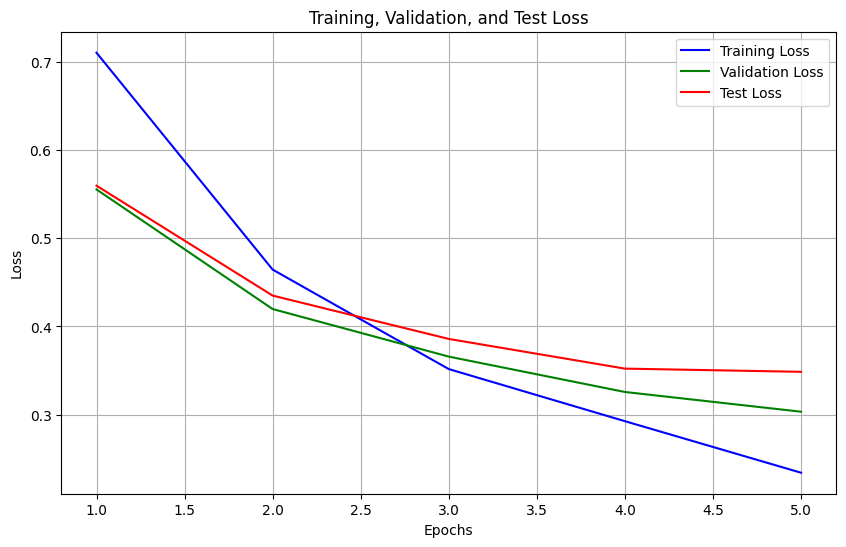

In [41]:
n_epochs = 5
history = defaultdict(list)

train_losses = []
valid_losses = []
test_losses = []

for epoch in range(n_epochs):
    # Training Phase
    model.train()
    torch.set_grad_enabled(True)

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_loader, leave=True, total=len(train_loader))
    for i, batch_data in enumerate(train_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS: {total_train_loss / (i+1):.4f}")

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS: {total_train_loss / len(train_loader):.4f} {metrics_to_string(metrics)}")
    train_losses.append(total_train_loss / len(train_loader))

    # Validation Phase
    model.eval()
    torch.set_grad_enabled(False)

    total_valid_loss = 0
    list_hyp, list_label = [], []

    valid_pbar = tqdm(valid_loader, leave=True, total=len(valid_loader))
    for i, batch_data in enumerate(valid_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        total_valid_loss += loss.item()
        list_hyp += batch_hyp
        list_label += batch_label

        valid_pbar.set_description(f"VALID LOSS: {total_valid_loss / (i+1):.4f}")

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS: {total_valid_loss / len(valid_loader):.4f} {metrics_to_string(metrics)}")
    valid_losses.append(total_valid_loss / len(valid_loader))

    # Test Phase
    total_test_loss = 0
    list_hyp_test, list_label_test = [], []

    test_pbar = tqdm(test_loader, leave=True, total=len(test_loader))
    for i, batch_data in enumerate(test_pbar):
        loss, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')

        total_test_loss += loss.item()
        list_hyp_test += batch_hyp
        list_label_test += batch_label

        test_pbar.set_description(f"TEST LOSS: {total_test_loss / (i+1):.4f}")

    metrics = document_sentiment_metrics_fn(list_hyp_test, list_label_test)
    print(f"(Epoch {epoch+1}) TEST LOSS: {total_test_loss / len(test_loader):.4f} {metrics_to_string(metrics)}")
    test_losses.append(total_test_loss / len(test_loader))

# Plot training, validation, and test losses
import matplotlib.pyplot as plt

plt.style.use('default')  # Pastikan latar belakang putih
plt.rcParams['figure.facecolor'] = 'white'

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, n_epochs + 1), valid_losses, label='Validation Loss', color='green')
plt.plot(range(1, n_epochs + 1), test_losses, label='Test Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss')
plt.legend()
plt.grid()
plt.show()


Confusion Matrix:


100%|██████████| 32/32 [00:12<00:00,  2.51it/s]


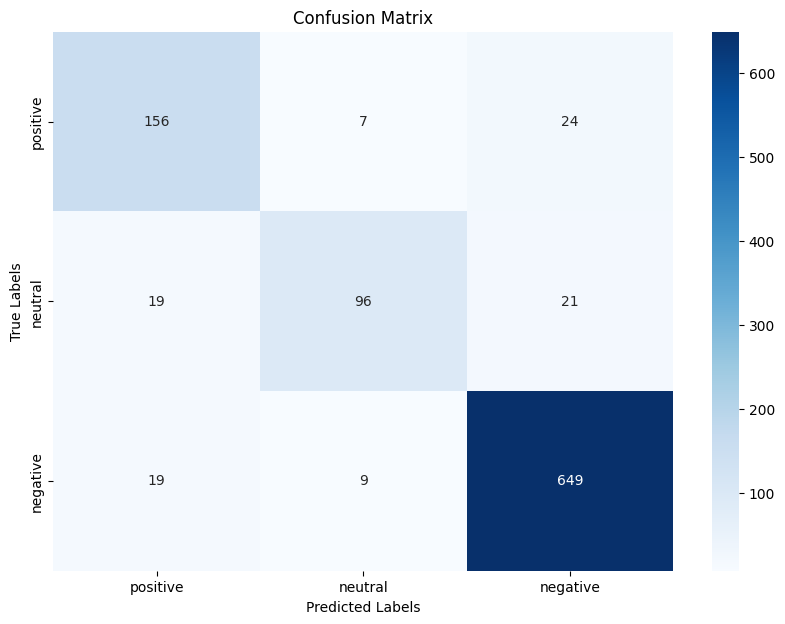


Classification Report:
              precision    recall  f1-score   support

    positive       0.80      0.83      0.82       187
     neutral       0.86      0.71      0.77       136
    negative       0.94      0.96      0.95       677

    accuracy                           0.90      1000
   macro avg       0.87      0.83      0.85      1000
weighted avg       0.90      0.90      0.90      1000


Accuracy: 0.90


In [42]:

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Setelah semua epoch selesai, hitung dan tampilkan confusion matrix
print("\nConfusion Matrix:")
final_hyp, final_label = [], []

# Evaluasi model pada valid_loader untuk mendapatkan prediksi akhir
total_loss, total_correct, total_labels = 0, 0, 0
list_hyp, list_label = [], []

model.eval()
torch.set_grad_enabled(False)

for batch_data in tqdm(valid_loader, leave=True, total=len(valid_loader)):
    _, batch_hyp, batch_label = forward_sequence_classification(model, batch_data[:-1], i2w=i2w, device='cuda')
    list_hyp += batch_hyp
    list_label += batch_label

# Hitung confusion matrix
cm = confusion_matrix(list_label, list_hyp)

# Tampilkan Confusion Matrix sebagai visualisasi heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=i2w.values(), yticklabels=i2w.values())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Tambahkan laporan lengkap dengan metrik lainnya
print("\nClassification Report:")
print(classification_report(list_label, list_hyp, target_names=i2w.values()))

# Hitung dan tampilkan akurasi
accuracy = accuracy_score(list_label, list_hyp)
print(f"\nAccuracy: {accuracy:.2f}")
